In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from factor_analyzer import FactorAnalyzer
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings("ignore")

df = pd.read_csv('data/csaf_2021.csv', sep=";")
df.replace(-1, 0, inplace=True)
labels = pd.read_csv('data/csaf_2021_labels.csv', sep=";")
labels = labels.replace("Separated, widowed, or divorced", "Separated")


#### Полезные функции

In [2]:
def map_q_column(ser):
    """Заменяет варианты ответов в вопросе на тексты варинатов ответа"""
    q_map = dict(zip(
            labels[labels['Q_NAME'] == ser.name]['Option_Num'],
            labels[labels['Q_NAME'] == ser.name]['Option_Text']
    ))
    return ser.map(q_map)

In [3]:
def get_dependency(q1, q2):
    """Возвращает значение альфы Кронбаха и коэффициента корреляции Спирмена
    для ответов на вопросы q1 и q2"""
    cron_alpha = pg.cronbach_alpha(df.loc[:, [q1, q2]])[0]
    spearman_coef = stats.spearmanr(df.loc[:, q1], df.loc[:, q2]).statistic
    return cron_alpha, spearman_coef

In [4]:
def get_dependency_for_battery(q):
    """Выводит значение альфы Кронбаха и коэффициента корреляции Спирмена для
    всех пар вопросов в блоке q"""
    if isinstance(q, list):
        q_block = q.copy()
    else:
        q_block = [i for i in df.columns if i.startswith(q)]
    res = []
    for i in range(len(q_block)):
        for j in range(i + 1, len(q_block)):
            cron_alpha, spearman_coef = get_dependency(q_block[i], q_block[j])
            res.append((q_block[i], q_block[j], cron_alpha, spearman_coef))
    for q1, q2, cron_alpha, spearman_coef in sorted(res, key=lambda x: (x[2], x[3]), reverse=True):
        print(f"{q1} and {q2} have {cron_alpha=} and {spearman_coef=}")

In [5]:
def factor_analysis(q, eigvalue_threshold=1.0, loading_threshold=0.6, num_factors=None):
    """Проводит факторный анализ для вопросов из блока q"""
    if isinstance(q, list):
        q_block = q.copy()
    else:
        q_block = [i for i in df.columns if i.startswith(q)]
    
    if num_factors is None:
        fa = FactorAnalyzer()
        fa.fit(df[q_block])

        ev, v = fa.get_eigenvalues()
        plt.figure(figsize=(5, 3))
        plt.plot(range(1, len(ev)+1), ev, marker='o')
        plt.title(f"Scree plot for {q}")
        plt.xlabel("Factor")
        plt.ylabel("Eigenvalue")
        plt.grid()
        plt.show()

        num_factors = len(ev[ev >= eigvalue_threshold])
        
    fa = FactorAnalyzer(n_factors=num_factors, rotation='varimax')
    fa.fit(df[q_block])

    loadings = pd.DataFrame(fa.loadings_, index=df[q_block].columns)
    loadings = round(loadings, 3)
    print(loadings)
    factor_groups = []
    for i in range(loadings.shape[1]):
        vars_in_factor = loadings[loadings.iloc[:, i].abs() >= loading_threshold].index.tolist()
        if vars_in_factor:
            factor_groups.append(vars_in_factor)
    for group in factor_groups:
        if len(group) == 1:
            cron_alpha = None
        else:
            cron_alpha = round(pg.cronbach_alpha(df[group])[0], 3)
        print(f"Cronbach's alpha for group {group} = {cron_alpha}")
    

### Поиск зависимостей факторов

#### Поиск зависимостей факторов в блоке про религию (Q1, Q2)

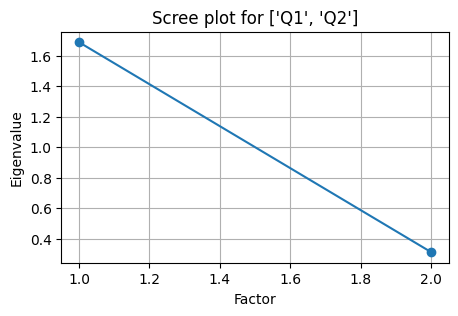

        0
Q1 -0.829
Q2 -0.829
Cronbach's alpha for group ['Q1', 'Q2'] = 0.616


In [6]:
factor_analysis(["Q1", "Q2"])

In [7]:
get_dependency("Q1", "Q2")

(0.6164624626295785, 0.7030262201255655)

In [8]:
df_z = pd.DataFrame(StandardScaler().fit_transform(df[["Q1", "Q2"]]), columns=["zQ1", "zQ2"])
pg.cronbach_alpha(df_z)[0], stats.spearmanr(df_z.loc[:, "zQ1"], df_z.loc[:, "zQ2"]).statistic


(0.8144856088318992, 0.7030262201255655)

#### Проверка зависимости факторов в блоке политических взглядов (Q4, Q5, Q6)

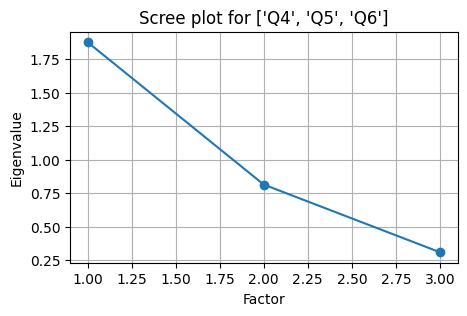

        0
Q4  0.820
Q5  0.841
Q6  0.343
Cronbach's alpha for group ['Q4', 'Q5'] = 0.81


In [9]:
factor_analysis(["Q4", "Q5", "Q6"])

In [10]:
get_dependency("Q4", "Q5")

(0.8104605119404822, 0.6895196835560208)

#### Поиск зависимостей факторов в блоке про медиа (Q9)

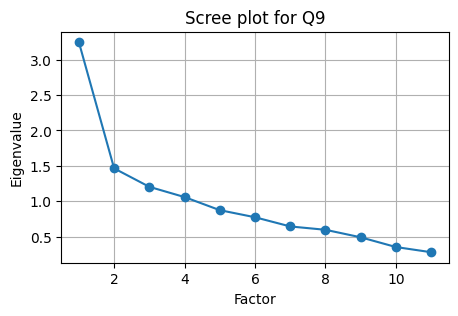

         0      1      2      3
Q9A  0.189  0.057  0.530 -0.057
Q9B -0.100  0.183  0.796  0.042
Q9C  0.094  0.191  0.391  0.244
Q9D  0.653  0.369  0.185 -0.038
Q9E  0.350  0.114 -0.016  0.050
Q9F  0.294  0.705  0.256  0.051
Q9G  0.258  0.714  0.190 -0.037
Q9H  0.929  0.097  0.107 -0.012
Q9I  0.341  0.269  0.022  0.183
Q9J  0.151  0.073  0.096  0.081
Q9K  0.082 -0.026  0.043  0.957
Cronbach's alpha for group ['Q9D', 'Q9H'] = 0.801
Cronbach's alpha for group ['Q9F', 'Q9G'] = 0.776
Cronbach's alpha for group ['Q9B'] = None
Cronbach's alpha for group ['Q9K'] = None


In [11]:
factor_analysis("Q9")

In [12]:
get_dependency_for_battery("Q9")

Q9D and Q9H have cron_alpha=0.8013180461633933 and spearman_coef=0.6732701007946474
Q9F and Q9G have cron_alpha=0.7764688242508817 and spearman_coef=0.6617885587252921
Q9D and Q9F have cron_alpha=0.653052310692819 and spearman_coef=0.5033578124949142
Q9D and Q9G have cron_alpha=0.6323632987779164 and spearman_coef=0.4767339136861139
Q9A and Q9B have cron_alpha=0.5803065856809198 and spearman_coef=0.4136799469330111
Q9F and Q9H have cron_alpha=0.5494279341487982 and spearman_coef=0.3747366099734636
Q9D and Q9I have cron_alpha=0.513050859606536 and spearman_coef=0.37532783033413575
Q9B and Q9C have cron_alpha=0.5128673051834289 and spearman_coef=0.35267509986825896
Q9E and Q9H have cron_alpha=0.5078413167243208 and spearman_coef=0.32821631973434184
Q9G and Q9H have cron_alpha=0.4948687611662299 and spearman_coef=0.32595760630288956
Q9B and Q9F have cron_alpha=0.4721126354280669 and spearman_coef=0.3276959460206344
Q9H and Q9I have cron_alpha=0.47113331703940786 and spearman_coef=0.316551

#### Проверка зависимости факторов в блоке страхов (Q16)

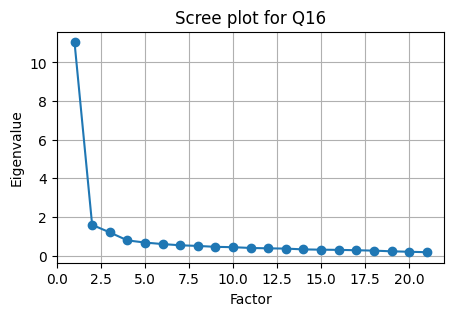

          0      1      2
Q16A  0.450  0.653  0.015
Q16B  0.313  0.695  0.069
Q16C  0.350  0.714  0.083
Q16D  0.370  0.768  0.062
Q16E  0.350  0.620  0.117
Q16F  0.441  0.629  0.028
Q16G  0.427  0.639 -0.064
Q16H  0.291  0.725  0.075
Q16I  0.520  0.435  0.184
Q16J  0.767  0.385  0.109
Q16K  0.680  0.471  0.095
Q16L  0.588  0.351  0.203
Q16M  0.590  0.393 -0.098
Q16N  0.591  0.281  0.067
Q16O  0.691  0.360  0.065
Q16P  0.079  0.037  0.567
Q16Q  0.135  0.036  0.780
Q16R  0.720  0.364  0.126
Q16S  0.735  0.378  0.117
Q16T  0.745  0.317  0.166
Q16U  0.715  0.351  0.227
Cronbach's alpha for group ['Q16J', 'Q16K', 'Q16O', 'Q16R', 'Q16S', 'Q16T', 'Q16U'] = 0.939
Cronbach's alpha for group ['Q16A', 'Q16B', 'Q16C', 'Q16D', 'Q16E', 'Q16F', 'Q16G', 'Q16H'] = 0.924
Cronbach's alpha for group ['Q16Q'] = None


In [13]:
factor_analysis("Q16")

In [14]:
get_dependency_for_battery(['Q16A', 'Q16B', 'Q16C', 'Q16D', 'Q16E', 'Q16F', 'Q16G', 'Q16H', "Q18R"])

Q16B and Q16D have cron_alpha=0.8433479987275043 and spearman_coef=0.7043280745041819
Q16F and Q16G have cron_alpha=0.8197786518487322 and spearman_coef=0.6836395183238779
Q16C and Q16D have cron_alpha=0.8135976904644422 and spearman_coef=0.6523064924665728
Q16B and Q16C have cron_alpha=0.8124022334685683 and spearman_coef=0.6657123566904583
Q16A and Q16G have cron_alpha=0.8123397901177707 and spearman_coef=0.6793814790233993
Q16A and Q16H have cron_alpha=0.7889262254261242 and spearman_coef=0.6253385393320829
Q16D and Q16H have cron_alpha=0.7866013040490865 and spearman_coef=0.6041831322641557
Q16A and Q16D have cron_alpha=0.78578103878166 and spearman_coef=0.6324456180226173
Q16D and Q16E have cron_alpha=0.7778491955072904 and spearman_coef=0.6110373095565055
Q16C and Q16H have cron_alpha=0.768083704879835 and spearman_coef=0.5656363114792944
Q16A and Q16F have cron_alpha=0.7643322088144981 and spearman_coef=0.6105075047451347
Q16D and Q16F have cron_alpha=0.7639983581247904 and spea

#### Проверка зависимости факторов в блоке страхов (Q17)

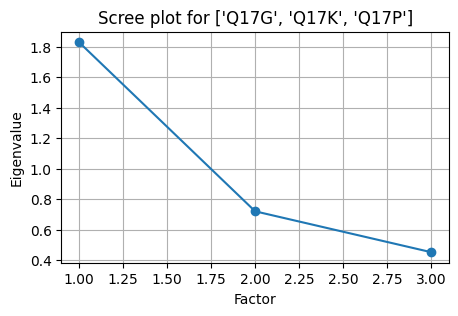

          0
Q17G -0.460
Q17K -0.726
Q17P -0.755
Cronbach's alpha for group ['Q17K', 'Q17P'] = 0.708


In [15]:
factor_analysis(["Q17G", "Q17K", "Q17P"])

In [16]:
get_dependency("Q17K", "Q17P")

(0.7078809784757656, 0.5180398633694763)

#### Проверка зависимости факторов в блоке теорий заговора Q20

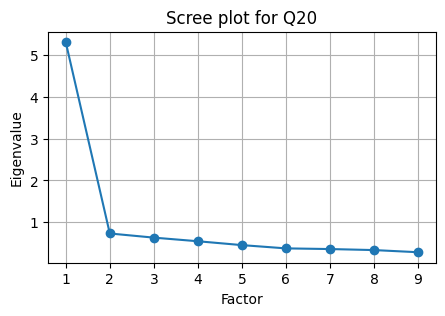

          0
Q20A  0.690
Q20B  0.820
Q20C  0.786
Q20D  0.587
Q20E  0.774
Q20F  0.738
Q20G  0.787
Q20H  0.783
Q20I  0.624
Cronbach's alpha for group ['Q20A', 'Q20B', 'Q20C', 'Q20E', 'Q20F', 'Q20G', 'Q20H', 'Q20I'] = 0.911


In [17]:
factor_analysis("Q20")

In [18]:
get_dependency_for_battery("Q20")

Q20B and Q20E have cron_alpha=0.8171390460092562 and spearman_coef=0.6890417416157555
Q20B and Q20H have cron_alpha=0.8090741581713883 and spearman_coef=0.6820398097828008
Q20B and Q20G have cron_alpha=0.771923641035553 and spearman_coef=0.6258281752717264
Q20C and Q20G have cron_alpha=0.7702967713640549 and spearman_coef=0.646599587854469
Q20C and Q20F have cron_alpha=0.7632581984492355 and spearman_coef=0.6232297818942107
Q20C and Q20H have cron_alpha=0.7585633097821345 and spearman_coef=0.6206215433282376
Q20B and Q20F have cron_alpha=0.7548215098184954 and spearman_coef=0.6078091212012013
Q20E and Q20H have cron_alpha=0.7547099551986971 and spearman_coef=0.5917232818087315
Q20E and Q20G have cron_alpha=0.7477767177276857 and spearman_coef=0.5931519884023061
Q20A and Q20E have cron_alpha=0.7470487529232732 and spearman_coef=0.5897136065849189
Q20F and Q20H have cron_alpha=0.7458004175319366 and spearman_coef=0.5907279346563241
Q20G and Q20H have cron_alpha=0.7439085570696875 and spe

In [19]:
factor_analysis("Q20", num_factors=3, loading_threshold=0.5)

          0      1      2
Q20A  0.568  0.301  0.280
Q20B  0.697  0.308  0.362
Q20C  0.354  0.515  0.556
Q20D  0.404  0.421  0.177
Q20E  0.721  0.267  0.295
Q20F  0.461  0.244  0.598
Q20G  0.493  0.446  0.415
Q20H  0.555  0.351  0.422
Q20I  0.238  0.718  0.218
Cronbach's alpha for group ['Q20A', 'Q20B', 'Q20E', 'Q20H'] = 0.86
Cronbach's alpha for group ['Q20C', 'Q20I'] = 0.726
Cronbach's alpha for group ['Q20C', 'Q20F'] = 0.763


#### Проверка зависимости факторов в блоке вопросов про иммигрантов (Q22)

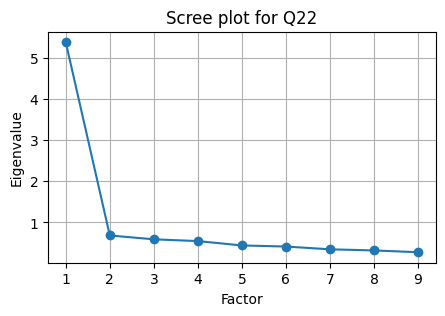

          0
Q22A  0.779
Q22B  0.654
Q22C  0.842
Q22D  0.804
Q22E  0.642
Q22F  0.769
Q22G  0.576
Q22H  0.751
Q22I  0.820
Cronbach's alpha for group ['Q22A', 'Q22B', 'Q22C', 'Q22D', 'Q22E', 'Q22F', 'Q22H', 'Q22I'] = 0.914


In [20]:
factor_analysis("Q22")

#### Поиск зависимостей факторов в блоке про коронавирус (Q29)

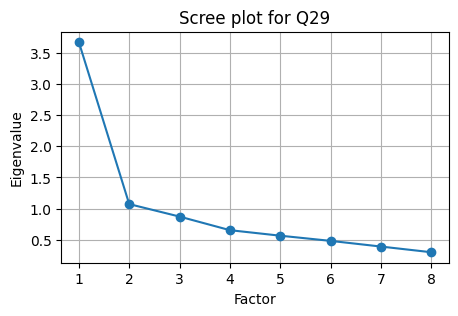

          0      1
Q29A  0.520 -0.459
Q29B -0.465  0.600
Q29C -0.126  0.591
Q29D  0.741 -0.076
Q29E  0.641 -0.423
Q29F  0.614 -0.217
Q29G -0.112  0.414
Q29H -0.517  0.421
Cronbach's alpha for group ['Q29D', 'Q29E', 'Q29F'] = 0.721
Cronbach's alpha for group ['Q29B'] = None


In [21]:
factor_analysis("Q29")

In [22]:
get_dependency("Q29D", "Q29E")

(0.6487059503498409, 0.5409002251350553)

In [23]:
get_dependency("Q29E", "Q29F")

(0.6064181894754825, 0.4622952187904752)

In [24]:
get_dependency("Q29D", "Q29F")

(0.6482308786762769, 0.5096823156586037)

#### Поиск зависимостей факторов в блоке про охрану и вооружение (Q33)

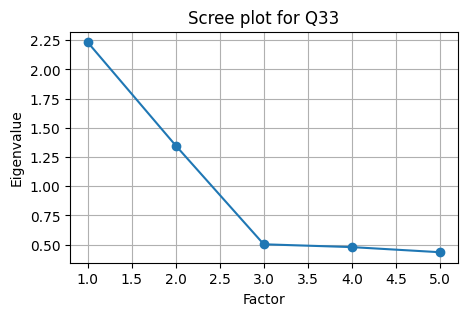

          0      1
Q33A  0.749 -0.070
Q33B  0.047  0.784
Q33C -0.242  0.625
Q33D  0.697 -0.016
Q33E  0.709 -0.207
Cronbach's alpha for group ['Q33A', 'Q33D', 'Q33E'] = 0.763
Cronbach's alpha for group ['Q33B', 'Q33C'] = 0.647


In [25]:
factor_analysis("Q33")

In [26]:
get_dependency_for_battery("Q33")

Q33A and Q33E have cron_alpha=0.6974595815718969 and spearman_coef=0.5558581221538293
Q33A and Q33D have cron_alpha=0.6760957501424516 and spearman_coef=0.5303787182942578
Q33D and Q33E have cron_alpha=0.6684910086004694 and spearman_coef=0.5093516344770337
Q33B and Q33C have cron_alpha=0.6470843431919582 and spearman_coef=0.48736006817237054
Q33B and Q33D have cron_alpha=0.025171706542089334 and spearman_coef=0.004624865416812745
Q33A and Q33B have cron_alpha=-0.020536904493345443 and spearman_coef=-0.02394958671946911
Q33B and Q33E have cron_alpha=-0.3015869458645568 and spearman_coef=-0.15354829955838656
Q33C and Q33D have cron_alpha=-0.3995367689635212 and spearman_coef=-0.14930426629091895
Q33A and Q33C have cron_alpha=-0.5833171536744004 and spearman_coef=-0.240603747267401
Q33C and Q33E have cron_alpha=-0.8294938262150322 and spearman_coef=-0.31033873351070107


#### Проверка зависимости факторов в блоке мистики (Q34)

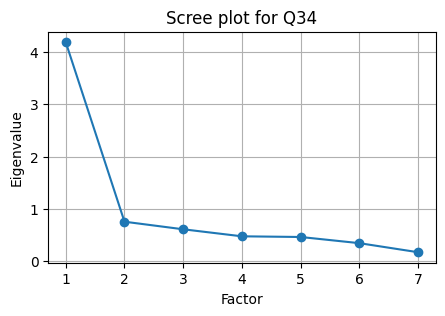

          0
Q34A -0.810
Q34B -0.820
Q34C -0.697
Q34D -0.671
Q34E -0.717
Q34F -0.650
Q34G -0.731
Cronbach's alpha for group ['Q34A', 'Q34B', 'Q34C', 'Q34D', 'Q34E', 'Q34F', 'Q34G'] = 0.887


In [27]:
factor_analysis("Q34")

In [28]:
get_dependency_for_battery("Q34")

Q34A and Q34B have cron_alpha=0.9057743001058978 and spearman_coef=0.8342416989241145
Q34C and Q34G have cron_alpha=0.7679796508266863 and spearman_coef=0.6461899850236621
Q34C and Q34E have cron_alpha=0.7395599002777371 and spearman_coef=0.6064036032388622
Q34A and Q34F have cron_alpha=0.7199755607442921 and spearman_coef=0.5542680230031071
Q34B and Q34D have cron_alpha=0.7137864779868901 and spearman_coef=0.5808712268328171
Q34B and Q34E have cron_alpha=0.7015197173787118 and spearman_coef=0.5438632092461776
Q34B and Q34G have cron_alpha=0.6982624591210091 and spearman_coef=0.546551058054607
Q34B and Q34F have cron_alpha=0.6945753037522788 and spearman_coef=0.5268445757324451
Q34A and Q34D have cron_alpha=0.6902974033637741 and spearman_coef=0.5348277032094698
Q34D and Q34G have cron_alpha=0.6887615210913538 and spearman_coef=0.5591455379548789
Q34A and Q34G have cron_alpha=0.6881906562154352 and spearman_coef=0.5320815393382697
Q34A and Q34E have cron_alpha=0.6873522849177012 and sp

### Препроцессинг

In [29]:
def recode_race(x):
    if x == 1: return 'White'
    if x == 2: return 'Black'
    if x == 6: return 'Asian'
    if x in [3,4,5]: return 'Latinx'
    return np.nan

In [30]:
def inverse_scale(q, df, lab):
    """Инвертирует шкалы в вопросах блока q"""
    max_val = lab[lab["Q_NAME"].str.startswith(q)]["Option_Num"].max()
    cols = [i for i in df.columns if i.startswith(q)]
    df.loc[:, cols] = max_val + 1 - df[cols]
    lab_ix = lab["Q_NAME"].str.startswith(q)
    lab.loc[lab["Q_NAME"].str.startswith(q), "Option_Num"] = max_val + 1 - lab[lab_ix]["Option_Num"]

In [31]:
def squeeze_afraid_scale(q, df):
    """Сжимает шкалу с вопросами про страх в not afraid / afraidдля вопросов блока q"""
    cols = [i for i in df.columns if i.startswith(q)]
    for col in cols:
        df[col] = np.where(df[col].isin([1, 2, 3]), 1, 0)

In [32]:
df_z = pd.DataFrame(StandardScaler().fit_transform(df[["Q1", "Q2"]]), columns=["zQ1", "zQ2"])

df.loc[df["NEWINCOME"].isin((9, 10, 99)), "NEWINCOME"] = np.nan
df.loc[df["NEWINCOME"] >= 12, "NEWINCOME"] -= 4
df.loc[df["PREGION"] == "Refused", "PREGION"] = np.nan

inverse_scale("Q33", df, labels)
inverse_scale("Q34", df, labels)
inverse_scale("Q29", df, labels)
inverse_scale("Q20", df, labels)
inverse_scale("Q22", df, labels)
inverse_scale("Q9", df, labels)

squeeze_afraid_scale("Q16", df)
squeeze_afraid_scale("Q17", df)
squeeze_afraid_scale("Q18", df)

In [33]:
# independent variables

# categorial
sex = map_q_column(df["I_SEX"])
age = map_q_column(df["I_AGE"])
race = df['PRACE'].apply(recode_race)
marital = map_q_column(df["I_MARITAL"])
region = map_q_column(df["PREGION"])

# numerical
# age = df["I_AGE"].copy()
income = df["NEWINCOME"].copy()
education = df["EDUC"].copy()
political = df["Q4"] + df["Q5"]
religiosity = pd.Series(df_z.sum(axis=1))
religiosity_square = religiosity ** 2
against_force = df[["Q33A", "Q33D", "Q33E"]].sum(axis=1)
support_force = df[["Q33B", "Q33C"]].sum(axis=1)
local_newspapers = df["Q9A"].copy()
national_newspapers = df["Q9B"].copy()
local_tv = df["Q9H"].copy()
national_tv = df["Q9D"].copy()
websites = df["Q9C"].copy()
social_media = df["Q9K"].copy()
immigrants_negative = df[['Q22A', 'Q22B', 'Q22C', 'Q22D', 'Q22E', 'Q22F', 'Q22H', "Q22I"]].sum(axis=1) 
fear_of_nature = df[['Q16A', 'Q16B', 'Q16C', 'Q16D', 'Q16E', 'Q16F', 'Q16G', 'Q16H']].sum(axis=1)
fear_of_war = df[['Q16A', 'Q16B', 'Q16C', 'Q16D', 'Q16E', 'Q16F', 'Q16G', 'Q16H', "Q18R"]].sum(axis=1)


In [34]:
# dependent variables

# Q17
fear_zg = pd.Series(np.where(df['Q17K'].isin([1, 2, 3]), 1, 0) + np.where(df['Q17P'].isin([1, 2, 3]), 1, 0))
# Q29
coronavirus = df[["Q29D", "Q29F"]].sum(axis=1)
# Q20
conspiracy = df[["Q20A", "Q20B", "Q20C", "Q20E", "Q20F", "Q20G", "Q20H", "Q20I"]].sum(axis=1)
# Q34
aliens = df[["Q34A", "Q34B"]].sum(axis=1)
supernatural_abilities = df[["Q34C", "Q34G"]].sum(axis=1)
bigfoot = df["Q34D"].copy()
spirits = df["Q34E"].copy()
ancients = df["Q34F"].copy()


In [35]:
columns_dep = ["aliens", "supernatural_abilities", "bigfoot", "spirits", "ancients", "fear_zg", "coronavirus", "conspiracy"]
columns_ind_cat = ["sex", "race", "marital", "region", "age"]
columns_ind_num = ["income", "education", "political", "religiosity", "religiosity_square", "against_force", "support_force",
               "local_newspapers", "national_newspapers", "local_tv", "national_tv", "websites", "social_media", "fear_of_nature", "fear_of_war",
               "immigrants_negative"]


In [36]:
df2 = pd.concat([aliens, supernatural_abilities, bigfoot, spirits, ancients, fear_zg, coronavirus, conspiracy, sex, 
           race, marital, region, age, income, education, political, religiosity, religiosity_square, against_force, 
           support_force, local_newspapers, national_newspapers, local_tv, national_tv, websites, social_media,
           fear_of_nature, fear_of_war, immigrants_negative], axis=1)
df2.columns = columns_dep + columns_ind_cat + columns_ind_num
# df2.loc[:, columns_dep] = StandardScaler().fit_transform(df2[columns_dep])
# df2.loc[:, columns_ind_num] = StandardScaler().fit_transform(df2[columns_ind_num])
df2 = df2[df2.notna().all(axis=1)]
df2.head(5)

,aliens,supernatural_abilities,bigfoot,spirits,ancients,fear_zg,coronavirus,conspiracy,sex,race,...,support_force,local_newspapers,national_newspapers,local_tv,national_tv,websites,social_media,fear_of_nature,fear_of_war,immigrants_negative
0,2,2,1,1,3,0,5,26,Female,White,...,8,5,3,6,5,5,6,7,8,24
1,4,4,2,2,2,0,4,16,Female,White,...,5,2,1,5,1,6,1,8,9,20
2,5,5,1,2,3,0,3,18,Male,White,...,5,5,4,5,4,3,5,8,9,9
3,2,2,1,1,1,0,2,15,Female,Black,...,4,4,5,6,5,6,6,7,8,18
4,3,2,2,1,3,0,3,8,Female,White,...,4,3,4,3,3,6,3,5,6,9


### Тестирование линейных моделей

In [37]:
def get_marginal_estimates_for_var(variable, model):
    """Считает предельные оценки веры / страха для одной категории"""
    means = df2[columns_ind_num].mean()
    modes = df2[columns_ind_cat].mode().T
    modes = pd.Series(modes[0], index=modes.index)
    marg_dict = pd.concat([means, modes]).to_dict()
    marg_dict[variable] = df2[variable].unique().tolist()
    marg = pd.DataFrame(marg_dict)

    pred = model.get_prediction(marg)
    summary = pred.summary_frame(alpha=0.05)
    marg['mean'] = summary['mean']
    marg['se'] = summary['mean_se']
    marg['ci_low'] = summary['mean_ci_lower']
    marg['ci_high'] = summary['mean_ci_upper']
    marg["category"] = variable
    marg["option"] = marg[variable].copy()
    return marg[['category', "option", 'mean', 'se', 'ci_low', 'ci_high']]


def get_marginal_estimates(model):
    """Считает предельные оценки веры / страха"""
    res = []
    for cat in columns_ind_cat:
        est = get_marginal_estimates_for_var(cat, model)
        res.append(est)
    return pd.concat(res, ignore_index=True)

In [38]:
GLOBAL_PARAMS = []

In [39]:
def create_model_and_get_estimates(dep_var, plot_title):
    model = smf.ols(f'{dep_var} ~ C(sex, Treatment(reference="Male")) + C(race, Treatment(reference="White")) '
                    '+ C(marital) + C(region) + C(age) + '
                    'income + education + political + religiosity + religiosity_square + against_force + '
                    'support_force + local_newspapers + national_newspapers + local_tv + '
                    'national_tv + websites + social_media + fear_of_nature + fear_of_war +'
                    'immigrants_negative',
                    data=df2).fit(disp=False)
    print(model.summary())
    GLOBAL_PARAMS.append((dep_var, model.params, model.rsquared_adj, model.fvalue, model.f_pvalue, model.mse_model))
    print()
    print()
    print("Marginal estimates")
    ests = get_marginal_estimates(model)
    print(ests)

    plt.figure(figsize=(10, 6))

    sns.barplot(
        data=ests,
        x='option',
        y='mean',
        hue='category',
        palette='Set2',
        capsize=0.1,
        errcolor='black',
        errwidth=1.5,
        ci=95
    )

    plt.errorbar(
        x=range(len(ests)),
        y=ests['mean'],
        yerr=ests['se'],
        fmt='none',
        c='black',
        capsize=5,
        lw=1.5
    )

    plt.ylabel("Level of fear / believe")
    plt.xticks(rotation=45, ha='right')
    plt.ylim(bottom=ests["mean"].min() * 0.75)
    plt.xlabel("Identity/Status")
    plt.title(f"Marginal Estimates of {plot_title}")
    plt.legend(title="Group", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

                            OLS Regression Results                            
Dep. Variable:                 aliens   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     5.911
Date:                Tue, 03 Jun 2025   Prob (F-statistic):           1.63e-19
Time:                        04:52:37   Log-Likelihood:                -1884.2
No. Observations:                1003   AIC:                             3826.
Df Residuals:                     974   BIC:                             3969.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

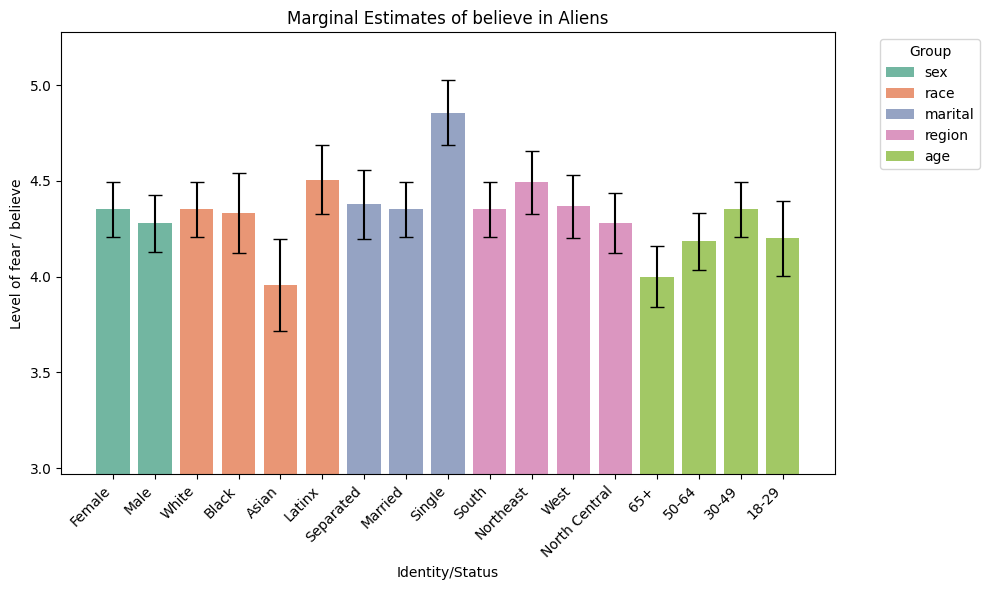

In [40]:
create_model_and_get_estimates("aliens", "believe in Aliens")

                              OLS Regression Results                              
Dep. Variable:     supernatural_abilities   R-squared:                       0.163
Model:                                OLS   Adj. R-squared:                  0.139
Method:                     Least Squares   F-statistic:                     6.775
Date:                    Tue, 03 Jun 2025   Prob (F-statistic):           2.58e-23
Time:                            04:52:38   Log-Likelihood:                -1681.0
No. Observations:                    1003   AIC:                             3420.
Df Residuals:                         974   BIC:                             3562.
Df Model:                              28                                         
Covariance Type:                nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

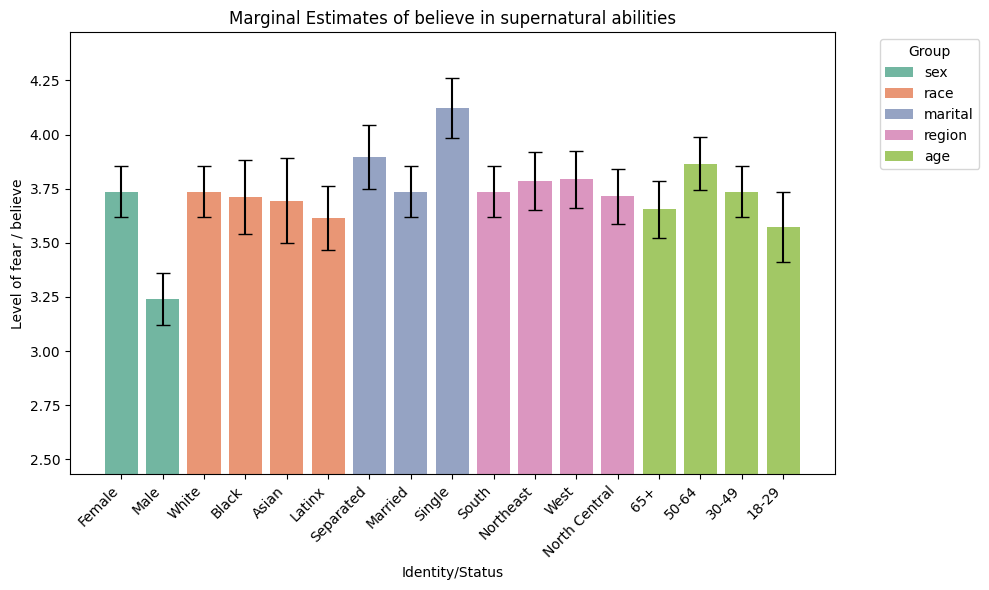

In [41]:
create_model_and_get_estimates("supernatural_abilities", "believe in supernatural abilities")

                            OLS Regression Results                            
Dep. Variable:                bigfoot   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     4.673
Date:                Tue, 03 Jun 2025   Prob (F-statistic):           4.11e-14
Time:                        04:52:38   Log-Likelihood:                -1112.3
No. Observations:                1003   AIC:                             2283.
Df Residuals:                     974   BIC:                             2425.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

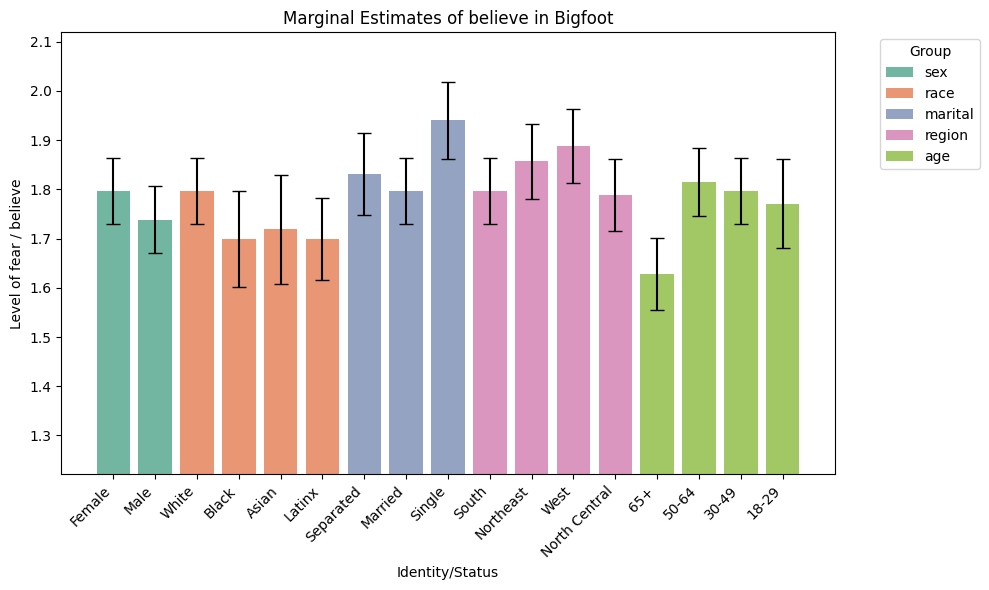

In [42]:
create_model_and_get_estimates("bigfoot", "believe in Bigfoot")

                            OLS Regression Results                            
Dep. Variable:                spirits   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     8.241
Date:                Tue, 03 Jun 2025   Prob (F-statistic):           9.42e-30
Time:                        04:52:39   Log-Likelihood:                -1274.9
No. Observations:                1003   AIC:                             2608.
Df Residuals:                     974   BIC:                             2750.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

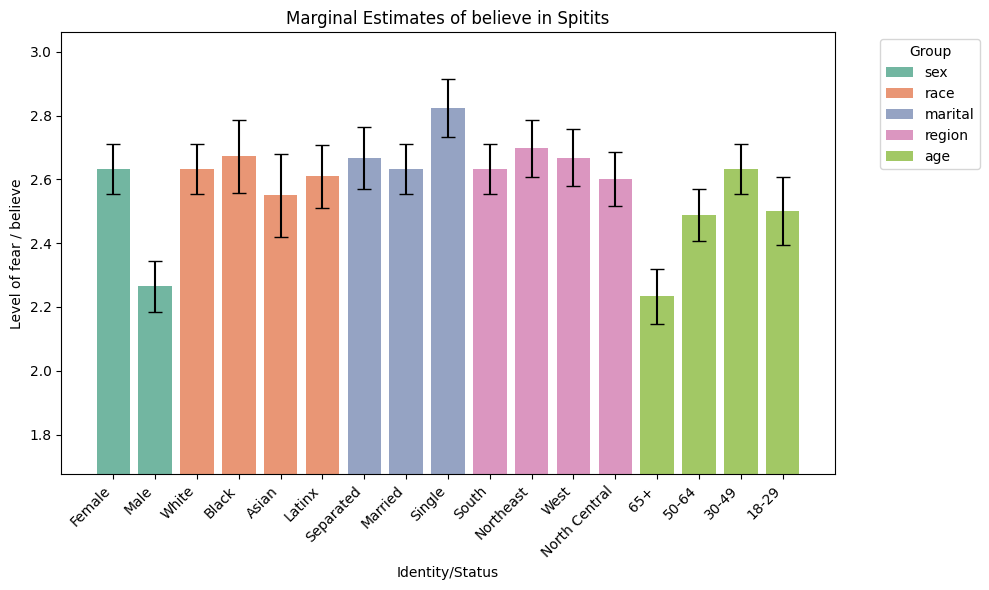

In [43]:
create_model_and_get_estimates("spirits", "believe in Spitits")

                            OLS Regression Results                            
Dep. Variable:               ancients   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     4.092
Date:                Tue, 03 Jun 2025   Prob (F-statistic):           1.26e-11
Time:                        04:52:39   Log-Likelihood:                -1215.3
No. Observations:                1003   AIC:                             2489.
Df Residuals:                     974   BIC:                             2631.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

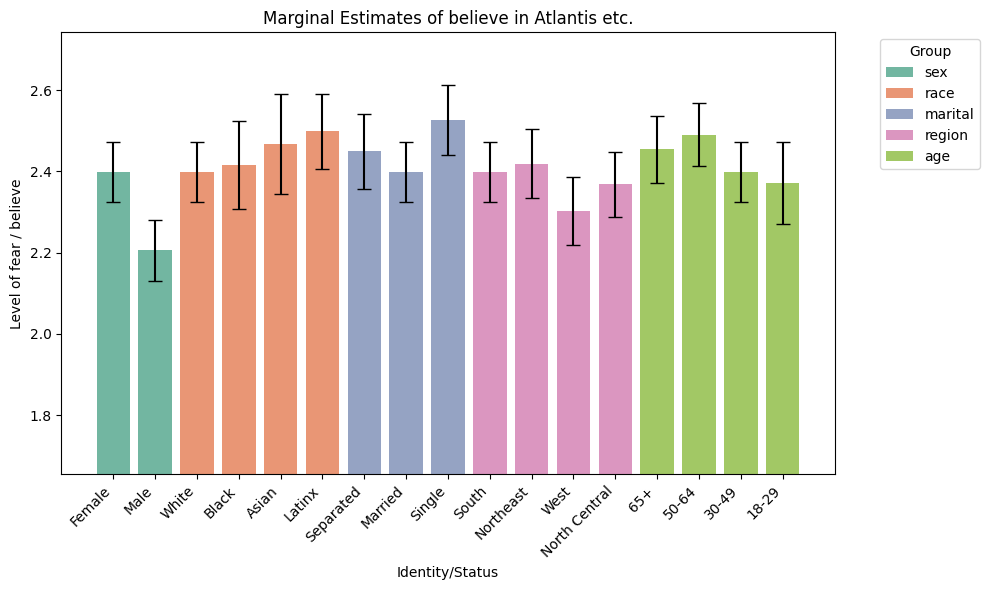

In [44]:
create_model_and_get_estimates("ancients", "believe in Atlantis etc.")

                            OLS Regression Results                            
Dep. Variable:                fear_zg   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     14.04
Date:                Tue, 03 Jun 2025   Prob (F-statistic):           3.11e-54
Time:                        04:52:40   Log-Likelihood:                -851.21
No. Observations:                1003   AIC:                             1760.
Df Residuals:                     974   BIC:                             1903.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

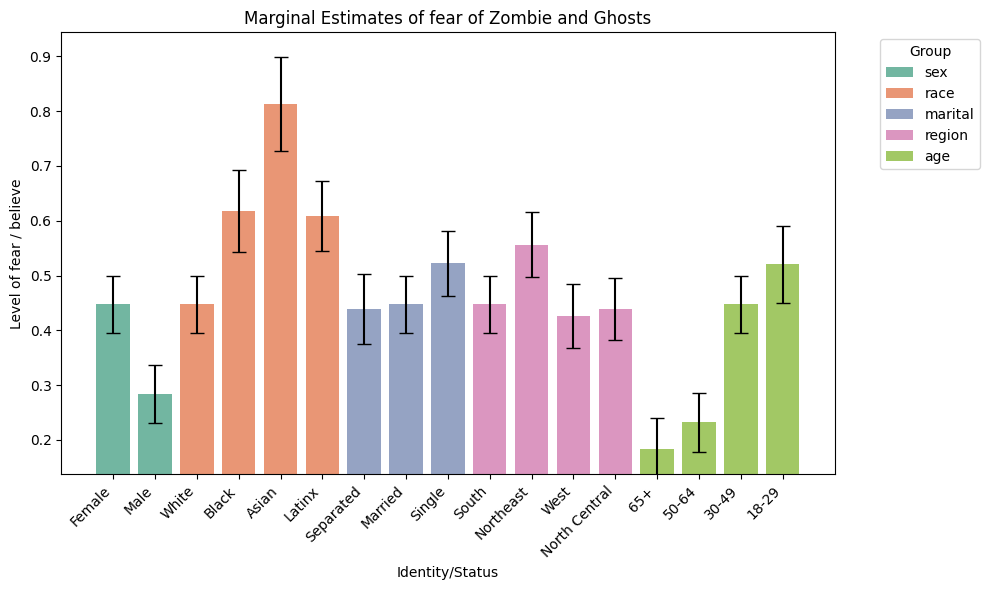

In [45]:
create_model_and_get_estimates("fear_zg", "fear of Zombie and Ghosts")

                            OLS Regression Results                            
Dep. Variable:            coronavirus   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.360
Method:                 Least Squares   F-statistic:                     21.14
Date:                Tue, 03 Jun 2025   Prob (F-statistic):           2.05e-81
Time:                        04:52:40   Log-Likelihood:                -1590.2
No. Observations:                1003   AIC:                             3238.
Df Residuals:                     974   BIC:                             3381.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

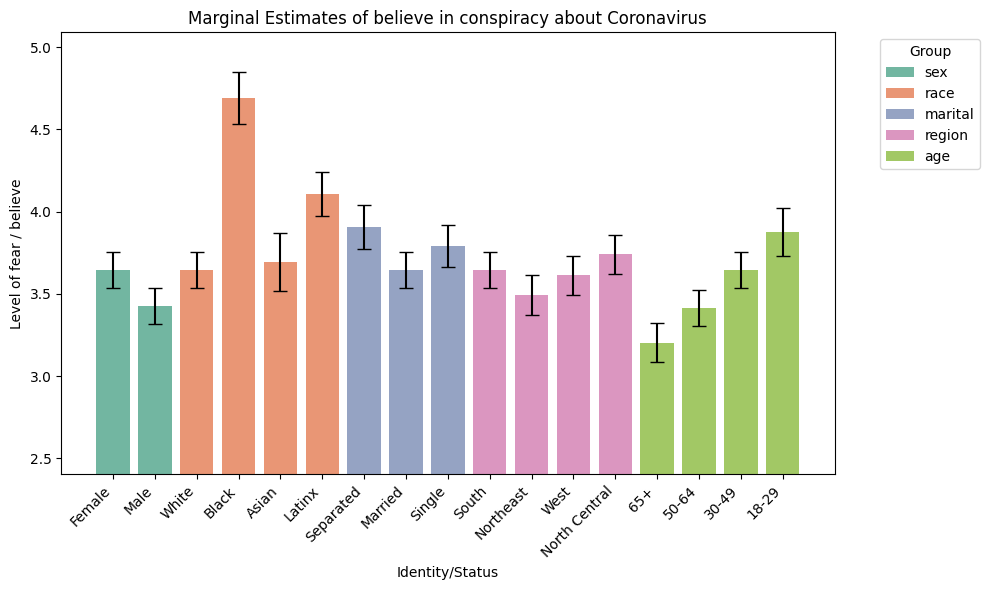

In [46]:
create_model_and_get_estimates("coronavirus", "believe in conspiracy about Coronavirus")

                            OLS Regression Results                            
Dep. Variable:             conspiracy   R-squared:                       0.329
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                     17.07
Date:                Tue, 03 Jun 2025   Prob (F-statistic):           3.31e-66
Time:                        04:52:41   Log-Likelihood:                -2997.6
No. Observations:                1003   AIC:                             6053.
Df Residuals:                     974   BIC:                             6196.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

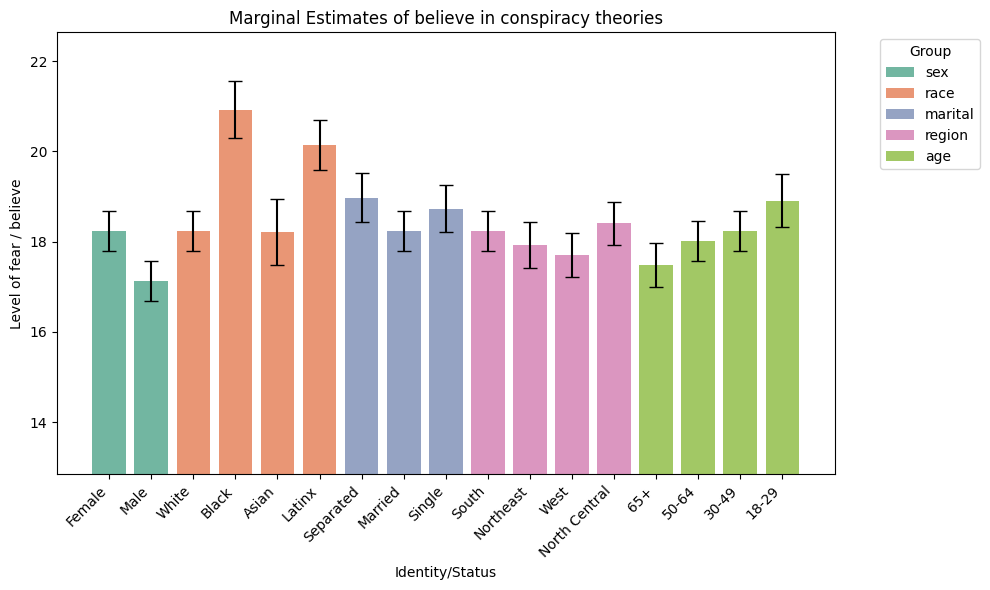

In [47]:
create_model_and_get_estimates("conspiracy", "believe in conspiracy theories")

In [48]:
ols_results = pd.concat([i[1] for i in GLOBAL_PARAMS], axis=1)
adj_r2 = pd.Series([i[2] for i in GLOBAL_PARAMS])
f_stat = pd.Series([i[3] for i in GLOBAL_PARAMS])
p_value = pd.Series([i[4] for i in GLOBAL_PARAMS])
model_stats = pd.concat([adj_r2, f_stat, p_value], axis=1).T
model_stats.index = ["adj_r2", "f_stat", "p_value"]
ols_results = pd.concat([ols_results, model_stats], axis=0)
ols_results.columns = [i[0] for i in GLOBAL_PARAMS]
ols_results = round(ols_results, 3)

In [49]:
ols_results

,aliens,supernatural_abilities,bigfoot,spirits,ancients,fear_zg,coronavirus,conspiracy
Intercept,3.143,2.845,1.597,1.957,1.838,-0.233,3.823,12.289
"C(sex, Treatment(reference=""Male""))[T.Female]",0.073,0.495,0.058,0.369,0.193,0.164,0.222,1.108
"C(race, Treatment(reference=""White""))[T.Asian]",-0.394,-0.041,-0.078,-0.083,0.069,0.366,0.047,-0.021
"C(race, Treatment(reference=""White""))[T.Black]",-0.017,-0.024,-0.098,0.039,0.017,0.170,1.045,2.686
"C(race, Treatment(reference=""White""))[T.Latinx]",0.155,-0.121,-0.097,-0.023,0.100,0.161,0.461,1.900
C(marital)[T.Separated],0.028,0.160,0.035,0.034,0.051,-0.009,0.261,0.738
C(marital)[T.Single],0.505,0.386,0.144,0.191,0.127,0.075,0.144,0.497
C(region)[T.Northeast],0.213,0.071,0.069,0.096,0.050,0.118,-0.245,-0.484
C(region)[T.South],0.072,0.021,0.009,0.032,0.030,0.009,-0.093,-0.172
C(region)[T.West],0.088,0.078,0.099,0.067,-0.065,-0.012,-0.128,-0.706
